In [1]:
import sys
print(sys.path)
sys.path.append("../KE/")
print(sys.path)

['/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks', '/Users/marcin/.pyenv/versions/3.10.11/lib/python310.zip', '/Users/marcin/.pyenv/versions/3.10.11/lib/python3.10', '/Users/marcin/.pyenv/versions/3.10.11/lib/python3.10/lib-dynload', '', '/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages']
['/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks', '/Users/marcin/.pyenv/versions/3.10.11/lib/python310.zip', '/Users/marcin/.pyenv/versions/3.10.11/lib/python3.10', '/Users/marcin/.pyenv/versions/3.10.11/lib/python3.10/lib-dynload', '', '/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages', '../KE/']


In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool, cv

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

from KE.classifier.prepare import split_dataset
from KE.dataclean import tables

In [40]:
import random
import numpy as np
import os
#import tensorflow as tf
#import torch

SEED_VALUE = 62

# Seed for Python's built-in random module
random.seed(SEED_VALUE)

# Seed for NumPy
np.random.seed(SEED_VALUE)

# Seed for TensorFlow
#tf.random.set_seed(SEED_VALUE)
`
# Seed for PyTorch
#torch.manual_seed(your_seed_value)
#torch.cuda.manual_seed_all(SEED_VALUE)

# Environment-level seed (less common)
#os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)

In [3]:
data = pd.read_csv("../data/merged/merged-kg_edges.tsv", header=0, sep="\t")

/var/folders/7w/ksxs106s7_sg14v6cb2y70vr0000gn/T/ipykernel_46471/2785372968.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/merged/merged-kg_edges.tsv", header=0, sep="\t")


In [4]:
data_pairs = data[['subject','object']].drop_duplicates()
data_pairs

,subject,object
0,NCBITaxon:1,BFO:0000040
1,NCBITaxon:10,NCBITaxon:1706371
2,NCBITaxon:100,NCBITaxon:99
3,NCBITaxon:100,mediadive.medium:7
4,NCBITaxon:100,mediadive.medium:428
...,...,...
1495724,NCBITaxon:147448,traits.cell_shape_enum:coccus
1495725,NCBITaxon:147448,ECOCORE:00000177
1495726,NCBITaxon:1240726,traits.cell_shape_enum:bacillus
1495727,NCBITaxon:1240783,traits.cell_shape_enum:bacillus


In [5]:
# Subset the DataFrame based on the substring in subject
data_pairs_clean = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
# Subset the DataFrame based on the substring in object
data_pairs_clean = data_pairs_clean[data_pairs_clean['object'].str.contains('mediadive.medium:')]
data_pairs_clean.to_csv("NCBITaxon_to_medium.tsv", sep="\t", header=True, index=False)
data_pairs_clean.shape

(32512, 2)

In [6]:
#add closure

data_pairs_chem = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
data_pairs_chem = data_pairs_chem[data_pairs_chem['object'].str.contains('CHEBI:')]
data_pairs_chem.shape

(38476, 2)

In [7]:
#add closure

data_pairs_go = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
data_pairs_go = data_pairs_go[data_pairs_go['object'].str.contains('GO:')]
data_pairs_go.shape

(2446, 2)

In [8]:
data_pairs_rest_all = data_pairs[data_pairs['subject'].str.contains('NCBITaxon:')]
data_pairs_rest = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('carbon_substrate:')]
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('pathways:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('cell_shape_enum:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('data_source:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('ENVO:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest2 = data_pairs_rest_all[data_pairs_rest_all['object'].str.contains('UBERON:')]
data_pairs_rest = pd.concat([data_pairs_rest, data_pairs_rest2], ignore_index=True)
data_pairs_rest.shape

(47187, 2)

In [9]:
data_df_pairs = pd.concat([data_pairs_chem, data_pairs_go], ignore_index=True)
data_df_pairs = pd.concat([data_df_pairs, data_pairs_rest], ignore_index=True)

data_df_pairs['Value'] = 1

# Step 2: Pivot the old DataFrame to form the new DataFrame structure
data_df = data_df_pairs.pivot(index='subject', columns='object', values='Value')

# Step 3: Fill NaN values with 0 to indicate no relationship
data_df = data_df.fillna(0)

# Optionally, convert the filled NaN values to integers if they were floats after pivot
data_df = data_df.astype(int)
data_df

object,CHEBI:132943,CHEBI:133748,CHEBI:14321,CHEBI:15361,CHEBI:15428,CHEBI:15792,CHEBI:15963,CHEBI:16015,CHEBI:16133,CHEBI:16193,...,traits.pathways:thiocyanate_oxidation,traits.pathways:thiocyanate_reduction,traits.pathways:thiosulfate_disproportionation,traits.pathways:thiosulfate_oxidation,traits.pathways:thiosulfate_oxidation_dark,traits.pathways:thiosulfate_reduction,traits.pathways:trithionate_oxidation,traits.pathways:uraninite_oxidation,traits.pathways:uranium_oxidation,traits.pathways:uranyl_reduction
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
NCBITaxon:1000560,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:1000561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:1000565,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:1000567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999702,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:999891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NCBITaxon:999892,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
subject_object_mapping = data_pairs_clean.set_index('subject')['object'].to_dict()

# Use the map function to create a new column in 'new_dataframe' from the 'subject' indices
data_df['medium'] = data_df.index.map(subject_object_mapping)


In [11]:
data_df['medium'].isna().sum()

20368

In [12]:
data_df = data_df[data_df['medium'].notna()]
data_df

object,CHEBI:132943,CHEBI:133748,CHEBI:14321,CHEBI:15361,CHEBI:15428,CHEBI:15792,CHEBI:15963,CHEBI:16015,CHEBI:16133,CHEBI:16193,...,traits.pathways:thiocyanate_reduction,traits.pathways:thiosulfate_disproportionation,traits.pathways:thiosulfate_oxidation,traits.pathways:thiosulfate_oxidation_dark,traits.pathways:thiosulfate_reduction,traits.pathways:trithionate_oxidation,traits.pathways:uraninite_oxidation,traits.pathways:uranium_oxidation,traits.pathways:uranyl_reduction,medium
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,mediadive.medium:J346
NCBITaxon:1000568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:110
NCBITaxon:1001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:668
NCBITaxon:1001240,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:92
NCBITaxon:100133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:J118
NCBITaxon:999552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:514
NCBITaxon:999611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:514


In [14]:
#data_pairs_clean = tables.rows_ad_cols_quant_filter(data_pairs)
#require at least 10 examples per class
data_df_clean = data_df.groupby('medium').filter(lambda x : len(x)>9)
data_df_clean

object,CHEBI:132943,CHEBI:133748,CHEBI:14321,CHEBI:15361,CHEBI:15428,CHEBI:15792,CHEBI:15963,CHEBI:16015,CHEBI:16133,CHEBI:16193,...,traits.pathways:thiocyanate_reduction,traits.pathways:thiosulfate_disproportionation,traits.pathways:thiosulfate_oxidation,traits.pathways:thiosulfate_oxidation_dark,traits.pathways:thiosulfate_reduction,traits.pathways:trithionate_oxidation,traits.pathways:uraninite_oxidation,traits.pathways:uranium_oxidation,traits.pathways:uranyl_reduction,medium
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,mediadive.medium:J346
NCBITaxon:1000568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:110
NCBITaxon:1001240,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:92
NCBITaxon:1002367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:J14
NCBITaxon:1002368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:J12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999549,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:514
NCBITaxon:999550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:J118
NCBITaxon:999552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,mediadive.medium:514


In [15]:
import pickle

pickle_filename = 'DeepWalkSkipGramEnsmallen_degreenorm_embedding_2023-11-29_10_24_15.pkl'

with open(pickle_filename, 'rb') as file:
    # Use the 'rb' mode to read in binary mode
    DeepWalkSkipGramEnsmallen_degreenorm_embedding = pickle.load(file)

/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
type(DeepWalkSkipGramEnsmallen_degreenorm_embedding)


embiggen.utils.abstract_models.embedding_result.EmbeddingResult

In [26]:
node_embed = DeepWalkSkipGramEnsmallen_degreenorm_embedding.get_all_node_embedding()[0]

In [27]:
node_embed2 = DeepWalkSkipGramEnsmallen_degreenorm_embedding.get_all_node_embedding()[1]

In [28]:
type(node_embed)

pandas.core.frame.DataFrame

In [29]:
node_embed


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
NCBITaxon:1000003,0.034162,2.503769,-2.521254,-0.998774,-2.742135,1.153177,-0.326960,-0.784282,1.923561,-2.507417,...,2.583111,1.742235,0.896255,-0.096745,0.901516,1.293776,4.571259,2.823058,-2.370578,0.003225
NCBITaxon:1000010,0.873408,-1.014702,-2.036614,-0.131085,-1.418003,1.370865,-0.351473,1.552916,0.643058,-0.383548,...,1.804202,0.910017,0.018341,-0.061875,0.009357,0.260595,1.218729,-0.441108,-0.665480,-1.523782
NCBITaxon:1000018,0.836734,0.737805,-1.208714,0.694495,-1.938871,1.876283,1.062288,-0.729784,-2.154326,-1.745164,...,0.787840,0.973486,0.244368,-0.694969,2.022704,-0.197461,2.508025,0.898255,-2.266548,-2.099144
NCBITaxon:1000025,1.704786,0.751442,-1.878025,0.046275,-0.744799,-1.451817,0.693720,-0.469832,-1.148474,-0.989597,...,2.107881,2.646951,1.561818,2.329682,-1.414949,1.956187,2.562458,-3.157948,0.431873,0.679800
NCBITaxon:1000032,-0.180706,2.292020,1.185783,-0.324598,2.630166,-0.637832,-0.937421,0.678562,-0.722792,-1.311928,...,-0.740935,-0.032497,-0.875030,3.550324,-1.150419,1.078851,1.445479,0.502446,-2.869281,-0.466696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:1870952,0.721869,-0.483938,1.426679,0.466388,0.955346,0.809142,1.171102,-2.393844,-1.513684,1.870957,...,1.868073,0.438586,-0.998786,-0.235357,-0.296142,-0.202677,1.641809,-0.249592,-0.788336,-0.236502
NCBITaxon:1411903,-0.518736,-1.461105,0.555898,0.864850,-1.513390,0.806430,1.104204,-1.028525,0.137026,1.305925,...,0.611599,1.468024,0.694122,0.579834,-0.797101,0.899245,1.099004,-0.210478,-0.598691,-0.102047
NCBITaxon:1662458,0.017640,-0.435596,0.550349,1.748698,-1.292305,0.860848,1.350728,-0.189668,-0.048366,1.821930,...,1.023233,0.002471,-0.883662,-0.116362,0.109781,-0.602058,0.899339,0.244731,-0.751950,1.447739
traits.cell_shape_enum:spirochete,-0.423940,0.011663,0.044189,2.205052,2.113882,-2.523444,0.144566,-0.716446,0.262490,1.156038,...,5.267982,1.357869,-1.517901,0.150374,-1.640092,1.437583,3.467234,0.058091,-2.419614,1.597180


In [32]:
node_embed2

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
NCBITaxon:1000003,-1.530631,1.500227,-1.966083,-0.781025,-3.138021,-0.575720,-1.341682,0.553951,3.068043,-0.747868,...,-0.444357,-2.267062,1.676837,-1.484273,2.303888,0.377596,1.063013,2.670341,0.664753,1.772700
NCBITaxon:1000010,-2.657711,-8.909390,3.004957,-3.180225,-3.245290,4.157020,-4.035218,5.315004,4.423868,5.371206,...,-5.224660,-6.267344,1.904229,-1.392649,2.474624,-0.644008,-2.457618,-1.346391,6.896717,-0.285799
NCBITaxon:1000018,-0.835942,-0.316762,-0.390592,0.911911,-1.777824,0.044125,0.152863,0.161783,-0.788315,0.071359,...,-2.535975,-2.847242,1.076215,-1.326464,3.207406,-1.093852,-1.117094,1.291189,0.964815,-0.260930
NCBITaxon:1000025,0.102671,0.058088,-1.677900,0.499372,-1.249592,-3.607228,-0.056898,0.501900,0.252922,0.338235,...,-1.340975,-1.241722,2.480640,1.303764,0.032665,0.861756,-0.890645,-2.829559,3.571947,2.347384
NCBITaxon:1000032,-2.466318,4.977441,-1.003546,1.202708,2.273057,-6.076805,-1.908673,1.977520,2.217580,-1.843979,...,-4.546107,-5.126123,1.256663,3.965969,0.451636,0.952686,-3.421886,1.906850,-0.030210,1.143744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:1870952,-0.349083,-1.034946,1.459091,0.680291,0.778549,-0.237423,0.251860,-1.513178,-1.465395,3.148853,...,0.607190,-2.016806,-0.594799,-1.051966,0.329765,-0.562670,-0.155799,0.356130,1.219676,0.188752
NCBITaxon:1411903,-1.669860,-1.588358,-0.231585,1.228443,-1.784577,-0.381106,0.351696,0.203108,0.876224,2.507635,...,-1.179318,-0.237554,1.896381,0.050112,-0.250263,1.128178,-0.618701,-0.135975,1.277126,-0.028080
NCBITaxon:1662458,-1.005798,-0.985491,0.574317,1.898990,-1.021015,-0.092572,1.012629,1.113158,0.888068,3.854199,...,-0.532580,-1.913176,-0.102891,-0.643312,0.089255,-0.427767,-1.284629,0.073773,1.194580,1.941174
traits.cell_shape_enum:spirochete,-3.186379,-0.829256,1.150265,2.174104,0.430517,-2.067553,0.283013,0.198657,1.202039,3.068019,...,1.457685,-3.007636,-0.737856,-1.695656,-1.173004,0.073137,0.015323,0.627454,1.368883,2.457222


In [33]:
data_df_clean_join_embed = data_df_clean.join(node_embed, how='left')
data_df_clean_join_embed

,CHEBI:132943,CHEBI:133748,CHEBI:14321,CHEBI:15361,CHEBI:15428,CHEBI:15792,CHEBI:15963,CHEBI:16015,CHEBI:16133,CHEBI:16193,...,90,91,92,93,94,95,96,97,98,99
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,1.581675,1.222566,-1.530396,-0.573811,0.735639,1.836487,3.715899,1.518221,0.514333,-0.916950
NCBITaxon:1000568,0,0,0,0,0,0,0,0,0,0,...,1.647906,1.578905,-0.437819,1.924184,-0.402445,0.460853,2.443324,-0.043332,-1.633474,1.101130
NCBITaxon:1001240,0,1,0,0,0,1,0,0,0,0,...,1.590870,-0.371999,-1.158993,-0.037462,-0.050779,-1.288025,0.543305,-1.219812,-1.711849,-0.170828
NCBITaxon:1002367,0,0,0,0,0,0,0,0,0,0,...,1.710954,1.695776,1.472700,1.880279,-1.845172,0.367787,3.661388,0.262377,0.029818,1.042601
NCBITaxon:1002368,0,0,0,0,0,0,0,0,0,0,...,3.035260,2.640473,0.079356,2.203046,0.863405,-0.597248,1.383406,1.410221,-0.860485,-0.059697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999549,0,0,0,0,0,0,0,0,0,0,...,1.361907,2.035633,0.262243,0.712917,1.324862,1.196779,1.836740,0.420518,-1.034814,0.138299
NCBITaxon:999550,0,0,0,0,0,0,0,0,0,0,...,1.602470,1.886078,-0.910057,0.184174,-2.432516,0.444178,1.663263,0.804977,-1.393293,1.153224
NCBITaxon:999552,0,0,0,0,0,0,0,0,0,0,...,2.608499,1.091274,-0.540300,2.537059,0.132859,0.078757,2.200061,0.948664,-0.373781,0.619758


In [35]:
data_df_clean_join_embed2 = data_df_clean_join_embed.join(node_embed2, how='left', lsuffix='_left', rsuffix='_right')
data_df_clean_join_embed2

,CHEBI:132943,CHEBI:133748,CHEBI:14321,CHEBI:15361,CHEBI:15428,CHEBI:15792,CHEBI:15963,CHEBI:16015,CHEBI:16133,CHEBI:16193,...,90_right,91_right,92_right,93_right,94_right,95_right,96_right,97_right,98_right,99_right
subject,,,,,,,,,,,,,,,,,,,,,
NCBITaxon:100,0,0,0,0,0,0,0,0,0,0,...,-1.840003,-3.165051,-0.384551,-2.141909,1.450294,0.717941,0.765263,1.872661,3.954408,0.000316
NCBITaxon:1000568,0,0,0,0,0,0,0,0,0,0,...,-1.385020,-1.461059,0.840868,1.341484,0.554329,-0.723683,-0.785412,0.293483,1.175020,2.720512
NCBITaxon:1001240,0,1,0,0,0,1,0,0,0,0,...,-1.909315,-4.069574,-0.167642,-0.365301,1.685032,-0.795175,-2.773258,-0.848697,1.665763,0.748714
NCBITaxon:1002367,0,0,0,0,0,0,0,0,0,0,...,-1.705374,-1.739397,2.715586,0.133864,-0.980189,-0.302596,0.661485,0.786186,3.386249,2.861758
NCBITaxon:1002368,0,0,0,0,0,0,0,0,0,0,...,0.211522,-0.532574,1.201135,1.030902,2.258415,-0.997084,-2.253096,2.412496,2.838119,0.461013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCBITaxon:999549,0,0,0,0,0,0,0,0,0,0,...,-1.461033,-1.547379,0.952166,0.822158,1.950332,0.642454,-1.066198,1.319553,2.191146,1.224273
NCBITaxon:999550,0,0,0,0,0,0,0,0,0,0,...,-1.495084,-0.642330,-0.210304,-0.430393,-1.611197,-0.398403,-0.329990,1.254608,1.199511,2.167080
NCBITaxon:999552,0,0,0,0,0,0,0,0,0,0,...,-0.265118,-2.901436,0.242870,1.488862,0.938842,-0.498235,-1.714050,1.361826,3.439340,1.806270


In [70]:
# Splitting the data into features and target labels
X = data_df_clean_join_embed2.drop('medium', axis=1)#data_pairs_clean[['subject']]
y = data_df_clean_join_embed2['medium']

# Convert the input labels column to a categorical type if it isn't
#X['subject'] = X['subject'].astype('category')

# Convert categorical columns to integers
#X['subject'] = X['subject'].cat.codes

In [71]:
len(set(data_df_clean_join_embed2['medium']))

106

In [72]:
len(set(data_df['medium']))

1416

In [73]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

train_data = Pool(data=X_train, label=y_train, cat_features=[0])
val_data = Pool(data=X_val, label=y_val, cat_features=[0])
test_data = Pool(data=X_test, label=y_test, cat_features=[0])

In [74]:
#6908
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(4144, 468)
(1382, 468)
(1382, 468)


In [41]:
## Splitting the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED_VALUE)
## Train the model
#train_data = Pool(data=X_train, label=y_train, cat_features=[0])
#test_data = Pool(data=X_test, label=y_test, cat_features=[0])


In [76]:
%%time
#only feature data (no embeddings) and below params = Accuracy: 0.3125904486251809
model = CatBoostClassifier(random_seed=SEED_VALUE,
                           iterations=10000, 
                           loss_function="MultiClass",
                           learning_rate=0.1, 
                           depth=4,#8 = 0.238 
                           l2_leaf_reg=3,
                           bagging_temperature=1,
                           random_strength=5,
                           verbose=100)
model.fit(train_data, 
          eval_set=val_data,
          early_stopping_rounds=50 
         )#, plot=True)

0:	learn: 4.4273534	test: 4.4392001	best: 4.4392001 (0)	total: 171ms	remaining: 28m 29s
100:	learn: 1.4013362	test: 1.9204384	best: 1.9204384 (100)	total: 16s	remaining: 26m 5s
200:	learn: 0.8131839	test: 1.5066104	best: 1.5066104 (200)	total: 31.5s	remaining: 25m 33s
300:	learn: 0.6039648	test: 1.3698123	best: 1.3698123 (300)	total: 46.9s	remaining: 25m 12s
400:	learn: 0.4905585	test: 1.3059387	best: 1.3059387 (400)	total: 1m 3s	remaining: 25m 8s
500:	learn: 0.4122801	test: 1.2639229	best: 1.2638727 (497)	total: 1m 18s	remaining: 24m 53s
600:	learn: 0.3610517	test: 1.2381350	best: 1.2381350 (600)	total: 1m 34s	remaining: 24m 36s
700:	learn: 0.3128922	test: 1.2159685	best: 1.2159685 (700)	total: 1m 50s	remaining: 24m 19s
800:	learn: 0.2777576	test: 1.2035292	best: 1.2035292 (800)	total: 2m 5s	remaining: 24m 2s
900:	learn: 0.2455957	test: 1.1933596	best: 1.1933570 (898)	total: 2m 20s	remaining: 23m 42s
1000:	learn: 0.2188947	test: 1.1862424	best: 1.1860769 (988)	total: 2m 36s	remaining:

In [77]:
# Predict on test data
y_pred = model.predict(test_data)
y_pred_proba = model.predict_proba(test_data)[:,1]  # Probabilities for the positive class

# Print metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
#print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

Accuracy: 0.5781476121562952

Classification Report:
                         precision    recall  f1-score   support

    mediadive.medium:1       0.55      0.62      0.59        66
  mediadive.medium:104       0.60      0.33      0.43        18
 mediadive.medium:104b       0.75      0.50      0.60         6
 mediadive.medium:104c       1.00      1.00      1.00         2
mediadive.medium:1076b       1.00      1.00      1.00         9
   mediadive.medium:11       0.68      0.87      0.76        30
  mediadive.medium:110       0.60      0.30      0.40        10
  mediadive.medium:119       0.60      1.00      0.75         3
 mediadive.medium:1203       0.00      0.00      0.00         2
mediadive.medium:1203a       0.00      0.00      0.00         2
  mediadive.medium:141       1.00      1.00      1.00         3
  mediadive.medium:144       1.00      1.00      1.00         2
 mediadive.medium:1523       1.00      0.33      0.50         3
  mediadive.medium:193       0.00      0.00      

/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marcin/Documents/VIMSS/ontology/KG-Hub/KG-Microbe/kg-microbe/notebooks/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 

In [78]:
# Predict on train data
y_pred_train = model.predict(train_data)
y_pred_proba_train = model.predict_proba(train_data)[:,1]  # Probabilities for the positive class

# Print metrics                                                                                                                        
print("Accuracy:", accuracy_score(y_train, y_pred_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_train))
#print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

Accuracy: 1.0

Classification Report:
                         precision    recall  f1-score   support

    mediadive.medium:1       1.00      1.00      1.00       199
  mediadive.medium:104       1.00      1.00      1.00        54
 mediadive.medium:104b       1.00      1.00      1.00        18
 mediadive.medium:104c       1.00      1.00      1.00         8
mediadive.medium:1076b       1.00      1.00      1.00        28
   mediadive.medium:11       1.00      1.00      1.00        91
  mediadive.medium:110       1.00      1.00      1.00        31
  mediadive.medium:119       1.00      1.00      1.00        10
 mediadive.medium:1203       1.00      1.00      1.00         7
mediadive.medium:1203a       1.00      1.00      1.00         6
  mediadive.medium:141       1.00      1.00      1.00        10
  mediadive.medium:144       1.00      1.00      1.00         6
 mediadive.medium:1523       1.00      1.00      1.00        10
  mediadive.medium:193       1.00      1.00      1.00         6


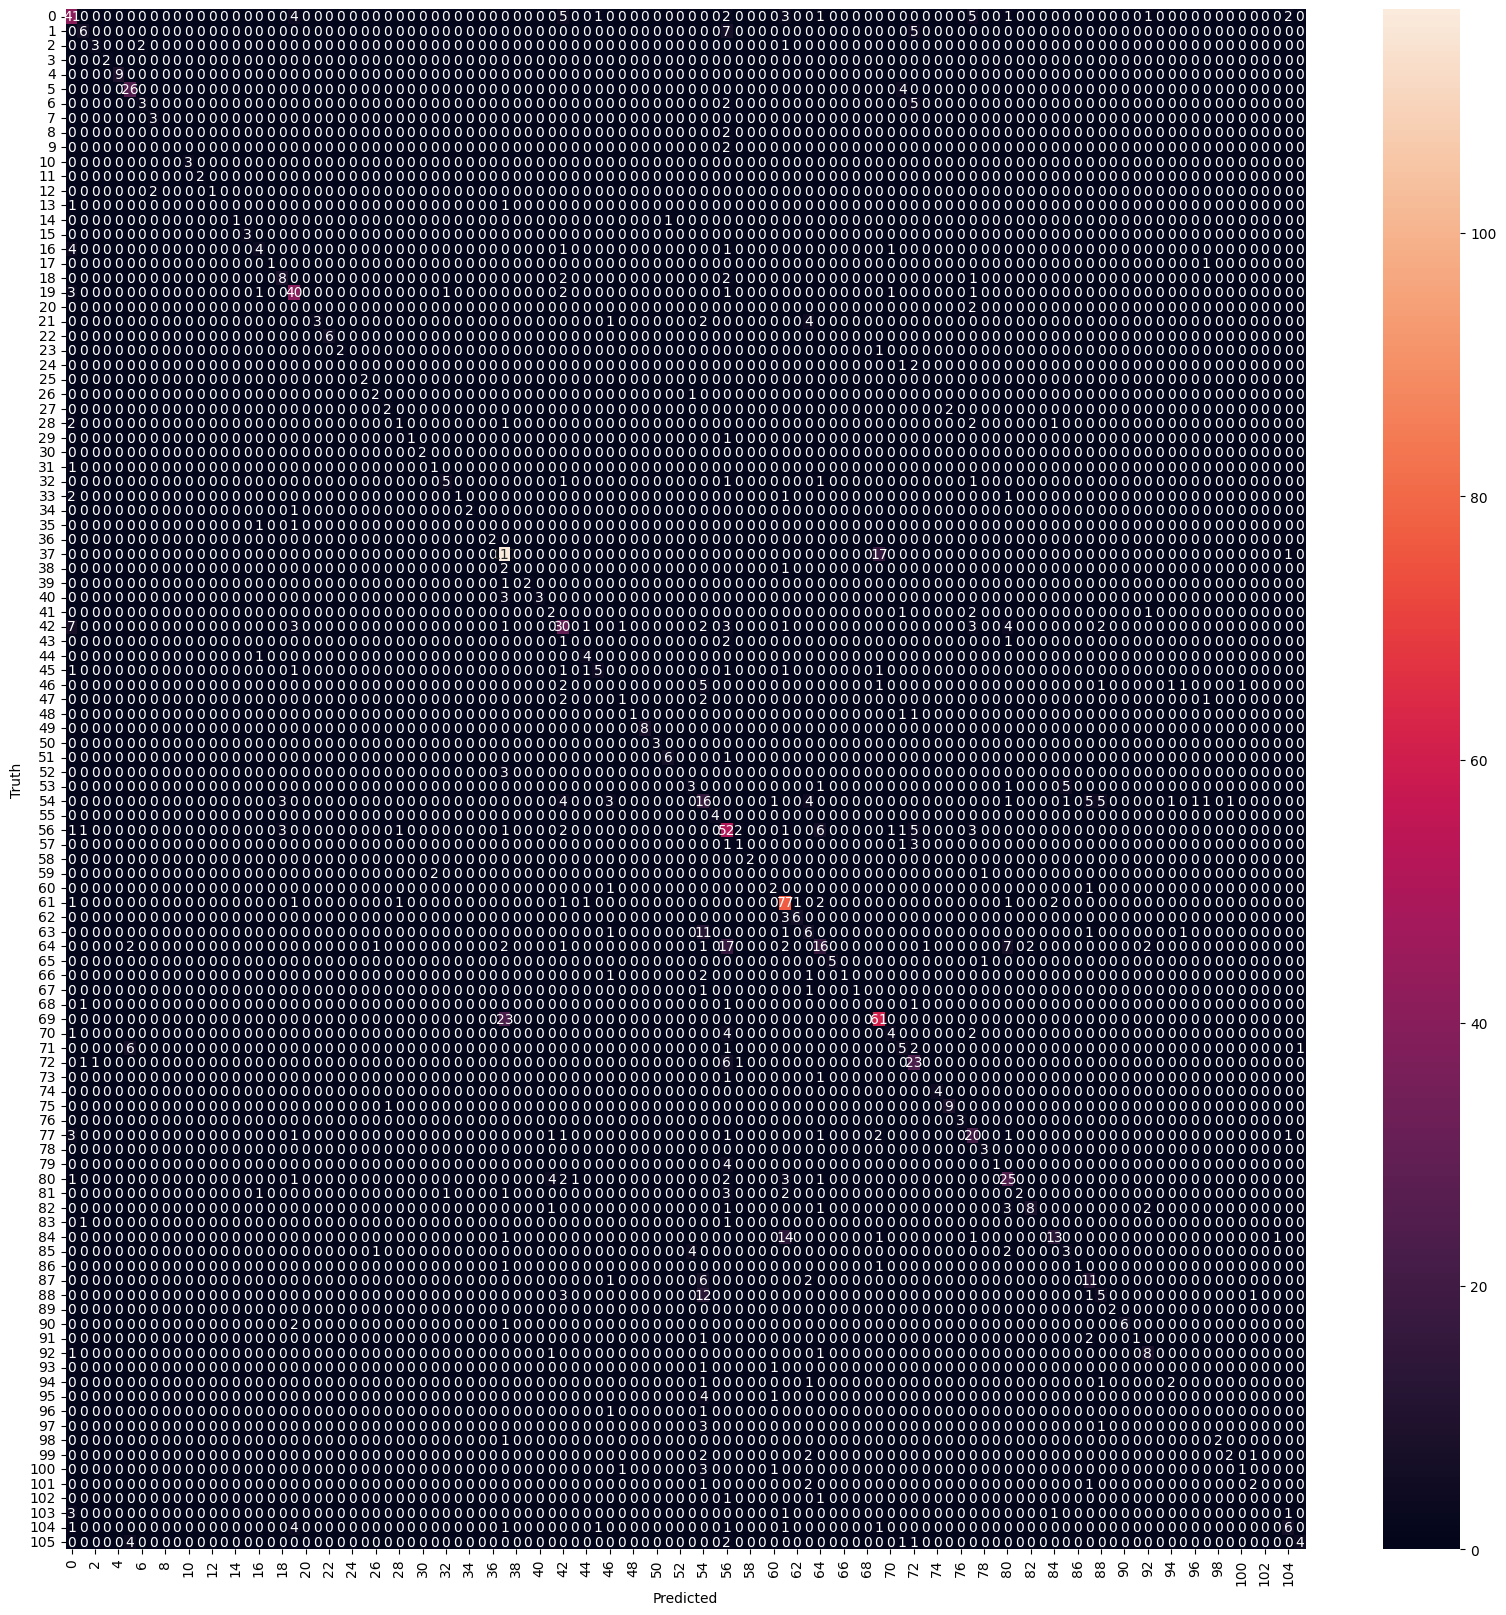

In [79]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# True labels are assumed to be in y_test
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.savefig('20231201_wembedding_test_confusion_matrix.pdf', format='pdf')
plt.show()